In [8]:
cd "D:/repo/CS420_Lab02_Connect-4"

D:\repo\CS420_Lab02_Connect-4


In [9]:
from pandas import read_csv

data_raw = read_csv("./data/connect-4.csv", header=0)
print(data_raw)

      a1 a2 a3 a4 a5 a6 b1 b2 b3 b4  ... f4 f5 f6 g1 g2 g3 g4 g5 g6 class
0      b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b   win
1      b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b   win
2      b  b  b  b  b  b  o  b  b  b  ...  b  b  b  b  b  b  b  b  b   win
3      b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b   win
4      o  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b   win
...   .. .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. ..   ...
67552  x  x  b  b  b  b  o  x  o  b  ...  b  b  b  o  o  x  b  b  b  loss
67553  x  x  b  b  b  b  o  b  b  b  ...  b  b  b  o  x  o  o  x  b  draw
67554  x  x  b  b  b  b  o  o  b  b  ...  b  b  b  o  x  x  o  b  b  loss
67555  x  o  b  b  b  b  o  b  b  b  ...  b  b  b  o  x  o  x  x  b  draw
67556  x  o  o  o  x  b  o  b  b  b  ...  b  b  b  x  b  b  b  b  b  draw

[67557 rows x 43 columns]


In [10]:
data_feature = data_raw.iloc[:, :-1]
data_label = data_raw.iloc[:, -1:]

x = data_feature.to_numpy()
y = data_label.to_numpy()

In [11]:
for i in range( 0, len( x[:] ) ):
    for j in range( 0, len( x[i][:] ) ):
        if x[i][j] == 'b':
            x[i][j] = -1
        elif x[i][j] == 'x':
            x[i][j] = 0
        elif x[i][j] == 'o':
            x[i][j] = 1
        else:
            print(x[i][j])
            raise Exception("Invalid Value")

In [12]:
print(x)
print(y)

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [0 0 -1 ... 1 -1 -1]
 [0 1 -1 ... 0 0 -1]
 [0 1 1 ... -1 -1 -1]]
[['win']
 ['win']
 ['win']
 ...
 ['loss']
 ['draw']
 ['draw']]


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

datasets = []

train_propotions = [0.4, 0.6, 0.8, 0.9]
for prop in train_propotions:
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=prop)
    
    for train_idx, test_idx in splitter.split(x, y):
        feature_train = []
        label_train = []
        
        feature_test = []
        label_test = []
        
        feature_train.extend([x[idx] for idx in train_idx])
        label_train.extend([y[idx] for idx in train_idx])    
        
        feature_test.extend([x[idx] for idx in test_idx])
        label_test.extend([y[idx] for idx in test_idx])
        
        datasets.append(
            {"feature_train" : feature_train,
             "label_train" : label_train,
             "feature_test" : feature_test,
             "label_test" : label_test})

In [14]:
for dataset in datasets:
    print( len(dataset["feature_train"]) / ( len(dataset["feature_train"]) + len(dataset["feature_test"]) ) )

0.3999881581479343
0.5999970395369836
0.7999911186109507
0.8999955593054754


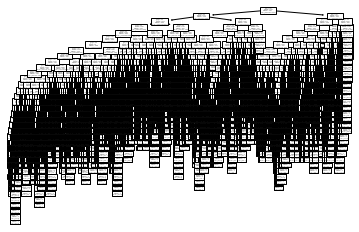

In [15]:
from sklearn.tree import (
    DecisionTreeClassifier,
    plot_tree
)

dec_trees = []
for dataset in datasets:
    dec_tree = DecisionTreeClassifier(criterion='entropy')
    
    dec_tree = dec_tree.fit(dataset["feature_train"], dataset["label_train"])
    plot_tree(dec_tree)
    
    dec_trees.append(dec_tree)

In [16]:
for dec_tree in dec_trees:
    accus = []
    for dataset in datasets:
        accus.append(dec_tree.score(dataset["feature_test"], dataset["label_test"]))
        
    for accu in accus:
        print(accu)
    print(f"Average: {sum(accus) / len(accus)}")
    print()

0.7232761810780807
0.8348073863005587
0.8348875074008288
0.83348134991119
Average: 0.8066131061726646

0.8973233008511163
0.7451060207970988
0.9012729425695678
0.8986086441681468
Average: 0.8605777270964824

0.9504132231404959
0.949857528771787
0.7533303730017762
0.9511545293072824
Average: 0.9011889135553354

0.9759220426791662
0.9763534766680235
0.97698342214328
0.7630254588513914
Average: 0.9230711000854652



              precision    recall  f1-score   support

        draw       0.24      0.25      0.24      3870
        loss       0.63      0.63      0.63      9981
         win       0.83      0.83      0.83     26684

    accuracy                           0.72     40535
   macro avg       0.57      0.57      0.57     40535
weighted avg       0.73      0.72      0.72     40535

              precision    recall  f1-score   support

        draw       0.27      0.27      0.27      2580
        loss       0.66      0.66      0.66      6654
         win       0.85      0.85      0.85     17789

    accuracy                           0.75     27023
   macro avg       0.59      0.59      0.59     27023
weighted avg       0.75      0.75      0.75     27023

              precision    recall  f1-score   support

        draw       0.26      0.27      0.27      1290
        loss       0.68      0.68      0.68      3327
         win       0.85      0.85      0.85      8895

    accuracy        

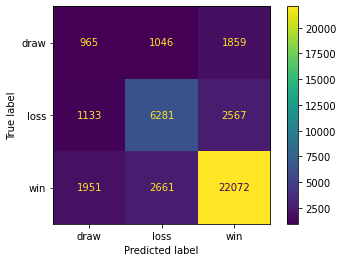

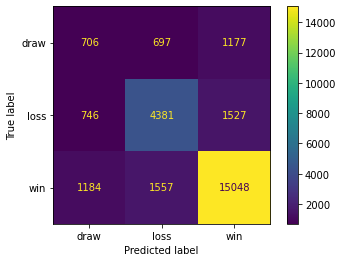

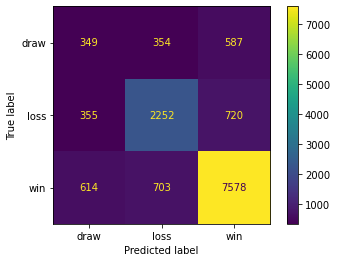

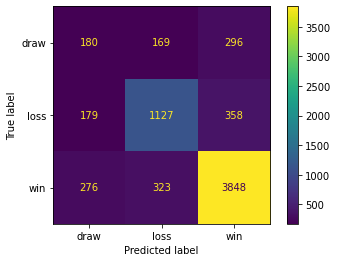

In [17]:
from numpy import concatenate
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

for dec_tree, dataset in zip(dec_trees, datasets):
    pred = dec_tree.predict(dataset["feature_test"])
    ground_truth = concatenate(dataset["label_test"])
    
    print( classification_report(ground_truth, pred) )
    
    conf_matrix = confusion_matrix(ground_truth, pred)
    ConfusionMatrixDisplay.from_predictions(ground_truth, pred)

0.7539224393132031
0.658303730017762
0.6617081113084665
0.6745115452930728
0.6851687388987566
0.6895352279455299
0.6972320899940794


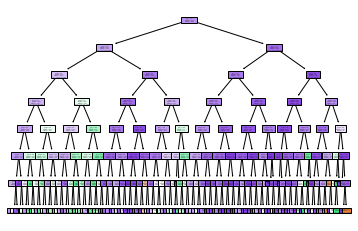

In [18]:
from sklearn.tree import (
    DecisionTreeClassifier,
    plot_tree
)
from sklearn.metrics import accuracy_score
from numpy import concatenate

dataset = datasets[2]

max_depths = (None, 2, 3, 4, 5, 6, 7)
for max_depth in max_depths:
    dec_tree = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    dec_tree = dec_tree.fit(dataset["feature_train"], dataset["label_train"])
    
    plot_tree(dec_tree, filled=True)
    
    pred = dec_tree.predict(dataset["feature_test"])
    ground_truth = concatenate(dataset["label_test"])
    
    print( accuracy_score(ground_truth, pred) )
    